This note works an example of partial pooling from equation 12.1 of Gelman, Hill, "Data Analysis Using Regression and Multilevel/Hierarchical Models", Cambridge 2007.

## Introduction

The topic of formula 12.1 is: how to partially pool data by hand, though this task is often handled by a hierarchical model solver. 

The idea is: we want to estimate the ideal mean of a value from a few observations at a location. The optimal linear un-biased estimator is to just take the average of the observed values, and hope this is close to the ideal unobserved mean.

The wrinkle in partial pooling is: if we have data from other (different buy related) locations, can we use that to improve our estimate?

Let's work this example with a few simplifying assumptions, using the `Python` `sympy` package to do the algebra.

In [1]:
# import packages
import sympy
from sympy.stats import E, Normal
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

Our idea is:

  * Each location has an unobserved mean value of examples drawn from this location, call this `LocationValue_j`.
  * The locations are related, in that the `LocationValue_j`s are all drawn from some common distribution. This is why we think pooling data could be useful.
  * For a given location, we figure some combination of the observations from the location, plus observations from other locations may be a lower expected error estimate than can be found using only observations from the location.

To execute this idea we need to define a great number of variables and their relations as follows.

In [2]:
# define initial variables
MeanLocationValue = sympy.Symbol("MeanLocationValue")  # center of distribution generating garages, unobserved
BetweenLocationsSD = sympy.Symbol("BetweenLocationsSD")  # how individual garages very from each other in expected behavior, unobserved
ObservedMean = sympy.Symbol("ObservedMean")  # mean of all observations, observed but some issues how to calculate
LocationValue_j = sympy.Symbol("LocationValue_j")  # actual expected behavior of a given garage, unobserved and the goal to estimate
LocationDistFactor_j = Normal("LocationDistFactor_j", mean=0, std=BetweenLocationsSD)  # how locations differ from each other, unobserved
def_LocationValue_j = MeanLocationValue + LocationDistFactor_j  #  generative definition of LocationDistFactor_j
PerObservationSD = sympy.Symbol("PerObservationSD", positive=True)  # sd of distribution generating observations per location, unobserved
n_j = sympy.Symbol("n_j", positive=True)  # number of observations at the j-th garage, observed
LocationMean_j = sympy.Symbol("LocationMean_j", mean=LocationValue_j, std=PerObservationSD)  # mean of all observations at garage j, observed
LocationCenterNoise_ji = Normal("LocationCenterNoise_ji", mean=0, std = PerObservationSD / sympy.sqrt(n_j))  # how mean observations at given location vary, unobserved
def_LocationMean_j = LocationValue_j + LocationCenterNoise_ji  # generative definition of LocationCenterNoise_ji
w = sympy.Symbol("w", positive=True)  # our weighting term picking how to pool specific and general observations, to solve for
estimate_j = sympy.Symbol("estimate_j")  # our estimate of the behavior of the j-th garage, to solve for
def_estimate_j = w * LocationMean_j + (1-w) * ObservedMean  # definition of our estimate
expected_error_term = LocationValue_j - estimate_j  # error of our estimate, to minimize square of

Formula 12.1 from Gelman and Hill is as follows.

<img src="IMG_1323.png">

This is a big equation with a "pooling strength" coefficient expanded into the expression. If we write the pooling coefficient as `w`, we can then re-write the above as the follosing.

In [3]:
def_estimate_j

LocationMean_j*w + ObservedMean*(1 - w)

That is: our estimate is `w` times using the observed per-location mean (`LocationMean_j`, the obvious estimate) plus `(1-w)` times the observed mean of all observations from all locations. Setting `w = 1` gives us the traditional "use only observations from the chosen location" solution. Setting `w = 0` gives us complete pooling, assuming there is not difference between locations. The trick is to find a `w` between `0` and `1` that might have lower expected square error. 

The 12.1 solution is a solution that picks `w` as the following.

In [4]:
neat_soln_approx = 1 / (1 + PerObservationSD**2 / (n_j * BetweenLocationsSD**2))

neat_soln_approx

1/(1 + PerObservationSD**2/(BetweenLocationsSD**2*n_j))

Some algebra shows this is the same as the Gelman and Hill citation (if we use the convention that `w = 1` when `n_j = 0`).

In [5]:
GH_soln =(n_j / PerObservationSD**2) / ( n_j / PerObservationSD**2 + 1 / BetweenLocationsSD**2)
assert (neat_soln_approx - GH_soln).together() == 0

GH_soln

n_j/(PerObservationSD**2*(n_j/PerObservationSD**2 + BetweenLocationsSD**(-2)))

This solution for `w` has some nice properties.

  * `w` goes to `1` (the standard simple solution) as `PerObservationSD` goes to zero. This can be read as: "there is no point in pooling of their is already little uncertainty in the obvious estimate.
  * `w` goes to `1` (the standard simple solution) as `n_j` goes to infinity. This can be read as: "there is no point in pooling if we already have a lot of data for the obvious estimate.
  * `w` goes to `0` (using all data) as `n_j` goes to zero (using the convention `1/infinity = 0`). This can be read as: "with no data for a new location, use the grand average."
  * `w` goes to `0` (combining all the data) as `PerObservationSD` goes to infinity. This can be read as: "combine all the data if the per-location uncertainty is very high."


The goal is to then derive this solution. First we will derive a similar solution, and then the identical solution.


## Reproducing the Gelman and Hill citation

We can match the Gelman and Hill citation by, during the solving, replacing the visible `MeanLocationValue` with our estimated `ObservedMean` (ignoring an an assumed small difference between them).

When we solve in that matter we get the Gelman and Hill cited `w` as follows.

In [6]:
error_term_approx = (
    expected_error_term
        .subs(estimate_j, def_estimate_j)  # definition of estimate_j
        .subs(ObservedMean, MeanLocationValue)  # this step is an approximation, using the unobserved MeanLocationValue as if it is the observed ObservedMean
        .subs(LocationMean_j, def_LocationMean_j)  # generative definition of LocationMean_j
        .subs(LocationValue_j, def_LocationValue_j)   # generative definition of LocationValue_j
).expand().simplify()


The simplifying substitution `MeanLocation` value for the `ObservedMean` is an approximation, and is why the total number of observations is not present in this estimate. This substitution is ignoring the uncertainty in estimating the grand mean. 

There is in fact an issue in how to estimate `ObservedMean` when different locations have very different numbers of observations. In this case an average where each observation contributes equally is sensitive to the between location variances, and an average where each location contributes equally is sensitive to per observation variances. What to put in for `ObservedMean` is essentially the entire estimation problem started over again.

Assuming we were happy with what we plugged in for `ObservedMean` we can continue our calculation as follows.

We claim this error term is equal to `A - B`, for the following `A`, `B`.

In [7]:
A = (1-w) * LocationDistFactor_j
B = w * LocationCenterNoise_ji


In [8]:
assert (error_term_approx - (A - B)).simplify() == 0
assert E(A).expand() == 0
assert E(B).expand() == 0

We can expand `E[(A - B)**2]` as `E[A**2] + E[B**2]` (using the independence of `A` and `B`, and their mean-zero properties).

In [9]:
soln_approx = sympy.solve(sympy.diff(E(A**2) + E(B**2), w), w)[0]

soln_approx

BetweenLocationsSD**2*n_j/(BetweenLocationsSD**2*n_j + PerObservationSD**2)

In [10]:
assert (soln_approx - neat_soln_approx).together().expand() == 0

neat_soln_approx

1/(1 + PerObservationSD**2/(BetweenLocationsSD**2*n_j))

And this, as promised matches the text book. I would suggest a slight preference for the exact solution over this one, thought the differences are small.

## Working an Example

Let's see the partial pooling inference in action. 

We will generate the data according to the above hierarchical design. We will then see how a pooled estimate, itself using estimate parameters, can in fact improve results.

In [11]:
rng = np.random.default_rng(2023)  # set state of pseudo random number generator

In [12]:
# set parameters to specific values
example_between_locations_sd = 3.0
example_per_observations_sd = 10.0
n_locations = 10
n_obs_per_location = 3

In [13]:
def generate_example_centers() -> pd.DataFrame:
    """generate the unobserved location centers"""
    example_location_value_mean = rng.normal(loc=0, scale=15, size=1)
    example_locations = pd.DataFrame({
        "location_id": range(n_locations),
        "effect": rng.normal(loc=example_location_value_mean, scale=example_between_locations_sd, size=n_locations)
    })
    return example_locations

In [14]:
example_locations = generate_example_centers()

In [15]:
example_locations

,location_id,effect
0,0,12.480676
1,1,4.947432
2,2,9.691985
3,3,6.698217
4,4,11.451937
5,5,8.429935
6,6,4.289738
7,7,7.137952
8,8,7.862549
9,9,9.176378


In [16]:
def generate_observations(example_locations: pd.DataFrame)-> pd.DataFrame:
    """
    generate observed data

    :param example_locations: the (unobserved) ground truth to generate from
    :return: observed data
    """
    assert isinstance(example_locations, pd.DataFrame)
    observations = []
    for j in range(example_locations.shape[0]):
        obs_j = pd.DataFrame({
            "location_id": j,
            "observation": rng.normal(loc=example_locations.effect[j], scale=example_per_observations_sd, size=n_obs_per_location),
        })
        observations.append(obs_j)
    observations = pd.concat(observations, ignore_index=True)
    return observations


In [17]:
observations = generate_observations(example_locations)

In [18]:
observations

,location_id,observation
0,0,3.410240
1,0,13.802057
2,0,26.529701
3,1,8.988453
4,1,-5.426702
5,1,-2.470594
6,2,22.326980
7,2,2.798745
8,2,16.772133
9,3,6.347742


In [19]:
# define the standard estimator
def standard_effect_estimate(observations: pd.DataFrame) -> pd.DataFrame:
    """
    Get the standard estimate of the effect at locations from observations.

    :param observations: the observations data frame
    :return: standard estimate of effect or mean by location
    """
    means = observations.loc[:, ["location_id", "observation"]].groupby(["location_id"]).mean().reset_index(drop=False, inplace=False)
    means.sort_values(["location_id"], inplace=True, ignore_index=True)
    means.rename(columns={"observation": "estimate"}, inplace=True)
    return means

In [20]:
# estimate the quality of the standard estimator
def get_sq_error_loss_std_estimate(*, location_id: int, example_locations: pd.DataFrame, observations: pd.DataFrame) -> float:
    """
    Show the square-error of estimate of the effect at location location_id from observations

    :parm location_id: which location to calculate for
    :param example_locations: the (unobserved) ground truth to compare to
    :param observations: the observations data frame
    :return: estimated square error of this estimation procedure
    """
    # get the standard estimates
    observed_means = standard_effect_estimate(observations=observations)
    # get the unobservable true effect for comparison
    true_effect = example_locations.loc[example_locations["location_id"] == location_id, "effect"].values[0]
    # calculate the square error of these estimates
    square_error = (observed_means.loc[observed_means["location_id"] == location_id, "estimate"].values[0] - true_effect)**2
    return square_error


In [21]:
# define the pooled estimator
def pooled_effect_estimate(observations: pd.DataFrame) -> pd.DataFrame:
    """
    Get the pooled estimate of effect

    :param observations: the observations data frame
    :return: pooled estimates
    """
    # get the standard estimates
    estimated_centers = standard_effect_estimate(observations=observations)
    # get the observed variance between locations
    between_location_var = np.var(estimated_centers["estimate"], ddof=1)
    # get the observed variance for each item at for each location
    combined = observations.merge(
        estimated_centers,
        on=["location_id"],
        how="left",
        )
    per_location_observation_var = np.sum((combined["observation"] - combined["estimate"])**2) / (combined.shape[0] - len(set(combined["location_id"])))
    # get the mean of all observations
    grand_mean = np.mean(combined["observation"])  # this quantity can be improved
    # get counts per group
    obs_count_frame = (
        pd.DataFrame({"location_id": observations["location_id"], "count": 1})
            .groupby(["location_id"])
            .sum()
            .reset_index(drop=False, inplace=False)
            .sort_values(["location_id"], inplace=False, ignore_index=True)
    )
    n_j = obs_count_frame["count"].values
    # get v, the pooling coefficient
    v = 1 / (1 + per_location_observation_var / (n_j * between_location_var))
    # build the pooled estimate
    pooled_estimate = v * estimated_centers["estimate"] + (1 - v) * grand_mean
    return pd.DataFrame({
        "location_id": estimated_centers["location_id"],
        "estimate": pooled_estimate
    })

In [22]:
# evaluate the pooled estimator quality
def get_sq_error_loss_pooled_estimate(*, location_id: int, example_locations: pd.DataFrame, observations: pd.DataFrame) -> float:
    """
    Show the square error of partial pooled out estimates of the effect at location location_id from observations

    :parm location_id: which location to calculate for
    :param example_locations: the (unobserved) ground truth to compare to
    :param observations: the observations data frame
    :return: estimated square error of this estimation procedure
    """
    # get the estimates
    pooled_estimates = pooled_effect_estimate(observations=observations)
    # get the unobservable true effect for comparison
    true_effect = example_locations.loc[example_locations["location_id"] == location_id, "effect"].values[0]
    # calculate the square error of these estimates
    square_error = (pooled_estimates.loc[pooled_estimates["location_id"] == location_id, "estimate"].values[0] - true_effect)**2
    return square_error

Now, let's try the estimators. In each case we the evaluation is returning square-error, so smaller is better.

In [23]:
# run the experiment for the standard estimator
std_est_loss = get_sq_error_loss_std_estimate(location_id=0, example_locations=example_locations, observations=observations)

std_est_loss

4.409957134811661

In [24]:
# run the experiment for the pooled estimator
pooled_est_loss = get_sq_error_loss_pooled_estimate(location_id=0, example_locations=example_locations, observations=observations)

pooled_est_loss

3.698066838111633

In [25]:
assert pooled_est_loss < std_est_loss

And we see, the pooled estimate has smaller expected square error loss that the standard estimate. That is: we have evidence the pooled estimate would be closer to new observations for a given location. Obviously we would want to further confirm by repeating the experiment more times.




In [26]:
def run_experiment() -> pd.DataFrame:
    example_locations = generate_example_centers()
    observations = generate_observations(example_locations)
    std_est_loss = get_sq_error_loss_std_estimate(location_id=0, example_locations=example_locations, observations=observations)
    pooled_est_loss = get_sq_error_loss_pooled_estimate(location_id=0, example_locations=example_locations, observations=observations)
    return pd.DataFrame({
        "std_loss": [std_est_loss],
        "pooled_loss": [pooled_est_loss,]
    })

In [27]:
experiments = pd.concat([run_experiment() for i in range(1000)], ignore_index=True)

In [28]:
means = experiments.mean()
means

std_loss       31.652005
pooled_loss    14.987383
dtype: float64

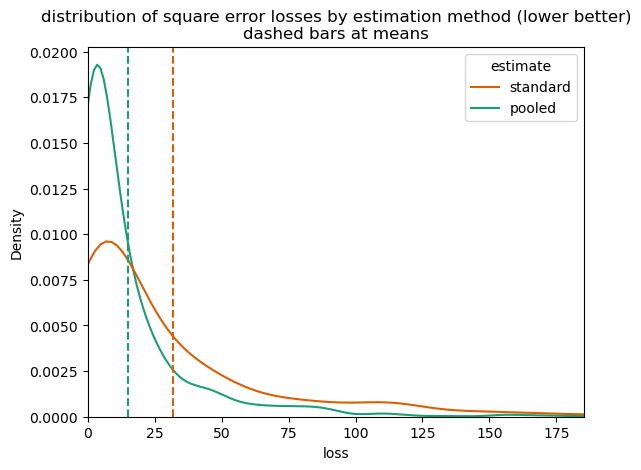

In [29]:
# plot the experiments
plt_frame = pd.concat([
    pd.DataFrame({"estimate": "standard", "loss": experiments["std_loss"]}),
    pd.DataFrame({"estimate": "pooled", "loss": experiments["pooled_loss"]}),
], ignore_index=True)
palette = ["#d95f02", "#1b9e77"]
sns.kdeplot(
    data=plt_frame,
    x="loss",
    hue="estimate",
    hue_order=["standard", "pooled"],
    palette=palette,
)
plt.title("distribution of square error losses by estimation method (lower better)\ndashed bars at means")
plt.xlim(0, np.quantile(plt_frame["loss"], 0.99))
plt.axvline(x=means["std_loss"], color=palette[0], linestyle="dashed")
plt.axvline(x=means["pooled_loss"], color=palette[1], linestyle="dashed")
plt.show()

The pooling doesn't so much make the errors tiny, instead it limits the frequency of large errors.

The method has been seen to work, even with estimated variances (instead of using the unobserved true generating variances).

## An Alternative

Another alternative is to re-write the mixing estimate as `w = X / n_j`, where `X` is an unknown constant. We can then estimate an effective `X` by cross-validation instead of using `X = PerObservationSD**2 / BetweenLocationsSD**2`. That is: we use the functional form from the above theory, and instead of estimating the variances instead pick `X` directly.

Or, delegate the entire task to a hierarchical modeling tool.

## Conclusion

The partial pooling improvement for estimating an unseen value from noisy observations depends on a single parameter `PerObservationSD**2 / (n_j * BetweenLocationsSD**2)`. This parameter compares the uncertainty in the observations from a single location, to the uncertainty per-location, scaled by how many observations we have at the location in question. When this ratio is small, we don't pool data- we just estimate the average value using data from one location. When this ratio is large, pooling is likely a useful variance reducing procedure.

Essentially the method is trading away variance (due to having very few samples) for bias (due to including samples that don't match the target location). If the different locations are sufficiently related, this can be an improving trade off in terms of expected square error.

In practice the above inference is made inside a hierarchical model solver. However, it is good to see the expect form of the pooling strategy.

Also, statistics remains relevant in the current age of AI. Often statistics has a characterization of what both what bad inference and optimal inference look like, no matter how they are implemented.